# "LNG를 키워드로 하는 지면기사 분석"
> "Climate X Data X Journalism"

- toc: false
- branch: master
- badges: true
- comments: true
- author: RyuHan
- categories: [LNG, climate]

🦡 재밌는거 하고 싶다 흑흑
⛱ 최근 LNG(액화천연가스)에 대한 국내외 인식이 매우 다르다는 이야기를 들었다. 해외에서는 '화석연료'라는 인식이 강해 부정적으로 인식되지만, 국내에선 이런 인식이 상대적으로 덜하다는 것이다. 덜한 정도가 아니라 브릿지 연료로서 긍정적으로 인식되기까지 하다는 것. 

⛎ LNG가 국내에서 어떻게 인식되는지 LNG를 다룬 기사를 통해 살펴보자. 해외 기사랑 비교하면 좋겠지만, 그러고보니 영어 뉴스 크롤링 아직 안 해봄.. ㅎㅎ ㅎ ㅎ ㅎ ㅎ ㅎㅎㅎ ㅎ 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 데이터 불러오기 

- 네이버 뉴스에서 'LNG'를 키워드로 검색
- 최신순 정열, '지면기사'만 추림 

In [153]:
import pandas as pd
df_1 = pd.read_csv('/content/drive/MyDrive/LNG지면기사만저장.csv')

In [154]:
df_1.head(3)

,agency,where,when,title,link,naver_link
0,중앙SUNDAY,T3면 1단,1일 전,"대우조선 부채율 547%, 작년 영업손실 1조7546억 ‘기초체력’ 떨어져",https://www.joongang.co.kr/article/25089042,https://n.news.naver.com/mnews/article/353/000...
1,한국경제언론사 선정,A27면 1단,1일 전,"[사설] 노사 협상 타결은 미봉…산은, 대우조선 원칙대로 처리하라",https://www.hankyung.com/opinion/article/20220...,https://n.news.naver.com/mnews/article/015/000...
2,서울경제언론사 선정,3면 TOP,1일 전,'최대불씨' 손배소 결론 못내…경영정상화서 매각까지 첩첩산중,https://www.sedaily.com/NewsView/268MEKIYUB,https://n.news.naver.com/mnews/article/011/000...


In [155]:
# 기사 본문이 든 df 불러오기 
df_2 = pd.read_csv('/content/LNG_NaverNew.csv')

In [156]:
df_2.head(3)

,link,content
0,https://n.news.naver.com/mnews/article/353/000...,"[<div class=""go_trans _article_content"" id=""di..."
1,https://n.news.naver.com/mnews/article/015/000...,"[<div class=""go_trans _article_content"" id=""di..."
2,https://n.news.naver.com/mnews/article/011/000...,"[<div class=""go_trans _article_content"" id=""di..."


In [157]:
print(len(df_1))
print(len(df_2))

4000
4000


In [158]:
df_1.rename(columns = {'link' :'agency_link', 'naver_link': 'link'}, inplace=True)
df_1.columns

Index(['agency', 'where', 'when', 'title', 'agency_link', 'link'], dtype='object')

In [159]:
df = pd.merge(df_1, df_2, how = 'inner', on = 'link')
len(df)

4000

In [160]:
df.head(3)

,agency,where,when,title,agency_link,link,content
0,중앙SUNDAY,T3면 1단,1일 전,"대우조선 부채율 547%, 작년 영업손실 1조7546억 ‘기초체력’ 떨어져",https://www.joongang.co.kr/article/25089042,https://n.news.naver.com/mnews/article/353/000...,"[<div class=""go_trans _article_content"" id=""di..."
1,한국경제언론사 선정,A27면 1단,1일 전,"[사설] 노사 협상 타결은 미봉…산은, 대우조선 원칙대로 처리하라",https://www.hankyung.com/opinion/article/20220...,https://n.news.naver.com/mnews/article/015/000...,"[<div class=""go_trans _article_content"" id=""di..."
2,서울경제언론사 선정,3면 TOP,1일 전,'최대불씨' 손배소 결론 못내…경영정상화서 매각까지 첩첩산중,https://www.sedaily.com/NewsView/268MEKIYUB,https://n.news.naver.com/mnews/article/011/000...,"[<div class=""go_trans _article_content"" id=""di..."


In [161]:
# 분석에 필요한 칼럼만 남기기
df = df[['agency', 'where', 'when', 'title', 'content']]

## 2. 데이터 전처리

In [ ]:
# konlpy 라이브러리 설치
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
#출처: https://biology-statistics-programming.tistory.com/32 [히비스서커스의 블로그:티스토리]

In [163]:
from konlpy.tag import Mecab
tokenizer = Mecab()

In [164]:
from konlpy.tag import Mecab
from tqdm import tqdm
import re
import pickle
import csv
import pandas as pd
from pandas import DataFrame 
import numpy as np

In [165]:
def clean_text(content):
    content = content.replace("[<div class=\"go_trans _article_content\" id=\"dic_area\"><strong class=\"media_end_summary\">", "").strip()
    content = content.replace(".", "").strip()
    content = content.replace("·", " ").strip()
    content = content.replace("\n", "").strip()
    pattern = '[^ ㄱ-ㅣ가-힣|0-9]+'
    content = re.sub(pattern=pattern, repl='', string=content)
    return content

In [166]:
df['content'] = df.content.apply(clean_text)

In [167]:
df.head(3)

,agency,where,when,title,content
0,중앙SUNDAY,T3면 1단,1일 전,"대우조선 부채율 547%, 작년 영업손실 1조7546억 ‘기초체력’ 떨어져",대우조선해양은 최악의 상황을 피했지만 그렇다고 앞날이 밝은 건 아니다 올해...
1,한국경제언론사 선정,A27면 1단,1일 전,"[사설] 노사 협상 타결은 미봉…산은, 대우조선 원칙대로 처리하라",51일을 끌어온 대우조선해양 하청업체 노동조합의 파업이 어제 노사협상 타결로 ...
2,서울경제언론사 선정,3면 TOP,1일 전,'최대불씨' 손배소 결론 못내…경영정상화서 매각까지 첩첩산중,대우조선 파업 종료 상처만 남은 하청파업 51일2조대 적자에 8000억 추가...


In [168]:
# agency를 클렌징 해보자 ~~~
df.agency.unique()

array(['중앙SUNDAY', '한국경제언론사 선정', '서울경제언론사 선정', '헤럴드경제', '서울신문',
       '서울신문언론사 선정', '매일경제', '동아일보', '중앙일보언론사 선정', '디지털타임스언론사 선정',
       '파이낸셜뉴스', '한국경제', '이데일리', '머니투데이언론사 선정', '디지털타임스', '서울경제', '전자신문',
       '문화일보', '세계일보언론사 선정', '한국일보', '조선일보', '동아일보언론사 선정', '강원도민일보',
       '머니투데이', '아시아경제언론사 선정', '매일신문', '한국일보언론사 선정', '이데일리언론사 선정',
       '매일경제언론사 선정', '한겨레언론사 선정', '파이낸셜뉴스언론사 선정', '한겨레', '국제신문', '세계일보',
       '코리아중앙데일리', '코리아헤럴드', '국민일보', '경향신문', '아시아경제', '부산일보언론사 선정',
       '강원일보', '중앙일보', '경향신문언론사 선정', '부산일보', '조선일보언론사 선정', '전자신문언론사 선정',
       '코리아중앙데일리언론사 선정', '대전일보', '국민일보언론사 선정', '문화일보언론사 선정', '강원일보언론사 선정',
       '대전일보언론사 선정', '헤럴드경제언론사 선정', '국제신문언론사 선정', '매일신문언론사 선정',
       '코리아헤럴드언론사 선정'], dtype=object)

In [169]:
len(df.agency.unique()) # 56개가 있다고 나오는데 ㅋㅋㅋ '언론사 선정' 킹받네... 언론사 선정 발라내자

56

In [170]:
def agency_pick(agency):
  agency = agency.replace("언론사 선정", "_언론사 선정").strip()
  return agency


In [171]:
df['agency'] = df.agency.apply(agency_pick)
df.head(3)

,agency,where,when,title,content
0,중앙SUNDAY,T3면 1단,1일 전,"대우조선 부채율 547%, 작년 영업손실 1조7546억 ‘기초체력’ 떨어져",대우조선해양은 최악의 상황을 피했지만 그렇다고 앞날이 밝은 건 아니다 올해...
1,한국경제_언론사 선정,A27면 1단,1일 전,"[사설] 노사 협상 타결은 미봉…산은, 대우조선 원칙대로 처리하라",51일을 끌어온 대우조선해양 하청업체 노동조합의 파업이 어제 노사협상 타결로 ...
2,서울경제_언론사 선정,3면 TOP,1일 전,'최대불씨' 손배소 결론 못내…경영정상화서 매각까지 첩첩산중,대우조선 파업 종료 상처만 남은 하청파업 51일2조대 적자에 8000억 추가...


In [175]:
df['agency_pick'] = df.agency.str.split('_').str[1]
df['agency'] = df.agency.str.split('_').str[0]

In [176]:
df.head(3)

,agency,where,when,title,content,agency_pick
0,중앙SUNDAY,T3면 1단,1일 전,"대우조선 부채율 547%, 작년 영업손실 1조7546억 ‘기초체력’ 떨어져",대우조선해양은 최악의 상황을 피했지만 그렇다고 앞날이 밝은 건 아니다 올해 들어 고...,NaN
1,한국경제,A27면 1단,1일 전,"[사설] 노사 협상 타결은 미봉…산은, 대우조선 원칙대로 처리하라",51일을 끌어온 대우조선해양 하청업체 노동조합의 파업이 어제 노사협상 타결로 끝났다...,언론사 선정
2,서울경제,3면 TOP,1일 전,'최대불씨' 손배소 결론 못내…경영정상화서 매각까지 첩첩산중,대우조선 파업 종료 상처만 남은 하청파업 51일2조대 적자에 8000억 추가손실세계...,언론사 선정


## 3. EDA

In [177]:
len(df.agency.unique()) # 총 29개 언론사 기사 

29

In [178]:
df.agency.unique()

array(['중앙SUNDAY', '한국경제', '서울경제', '헤럴드경제', '서울신문', '매일경제', '동아일보',
       '중앙일보', '디지털타임스', '파이낸셜뉴스', '이데일리', '머니투데이', '전자신문', '문화일보',
       '세계일보', '한국일보', '조선일보', '강원도민일보', '아시아경제', '매일신문', '한겨레', '국제신문',
       '코리아중앙데일리', '코리아헤럴드', '국민일보', '경향신문', '부산일보', '강원일보', '대전일보'],
      dtype=object)

In [179]:
len(df[df.agency_pick == '언론사 선정']) # 4000개 기사 중 '언론사 선정'은 992개 

992

In [180]:
# 날짜 분포 
# 일주일 전까지 날짜가 N일 전으로 나옴 
def change_to_date(when):
  when = when.replace("1일 전", "2022.07.23.").strip()
  when = when.replace("2일 전", "2022.07.22.").strip()
  when = when.replace("3일 전", "2022.07.21.").strip()
  when = when.replace("4일 전", "2022.07.20.").strip()
  when = when.replace("5일 전", "2022.07.19.").strip()
  when = when.replace("6일 전", "2022.07.18.").strip()
  when = when.replace("7일 전", "2022.07.19.").strip()
  when = when.replace(".", '').strip()
  return when 

In [181]:
df.when = df.when.apply(change_to_date)
df.head(3)

,agency,where,when,title,content,agency_pick
0,중앙SUNDAY,T3면 1단,20220723,"대우조선 부채율 547%, 작년 영업손실 1조7546억 ‘기초체력’ 떨어져",대우조선해양은 최악의 상황을 피했지만 그렇다고 앞날이 밝은 건 아니다 올해 들어 고...,NaN
1,한국경제,A27면 1단,20220723,"[사설] 노사 협상 타결은 미봉…산은, 대우조선 원칙대로 처리하라",51일을 끌어온 대우조선해양 하청업체 노동조합의 파업이 어제 노사협상 타결로 끝났다...,언론사 선정
2,서울경제,3면 TOP,20220723,'최대불씨' 손배소 결론 못내…경영정상화서 매각까지 첩첩산중,대우조선 파업 종료 상처만 남은 하청파업 51일2조대 적자에 8000억 추가손실세계...,언론사 선정


후 이제 좀 봐줄만해 ⚡

In [182]:
from datetime import date, datetime

In [183]:
type(df.iloc[0].when)

str

In [184]:
def to_date_type(when):
  date_object = datetime.strptime(when,'%Y%m%d')
  return date_object

In [185]:
df.when = df.when.apply(to_date_type)

In [186]:
# 언제부터 언제까지 기사가 수집됐을까 ? 2021년 9월 2일부터 2022년 7월 23일까지 324일간 기사가 수집됨 
print(max(df.when))
print(min(df.when))
print(max(df.when) - min(df.when))

2022-07-23 00:00:00
2021-09-02 00:00:00
324 days 00:00:00


In [187]:
df.agency.unique()

array(['중앙SUNDAY', '한국경제', '서울경제', '헤럴드경제', '서울신문', '매일경제', '동아일보',
       '중앙일보', '디지털타임스', '파이낸셜뉴스', '이데일리', '머니투데이', '전자신문', '문화일보',
       '세계일보', '한국일보', '조선일보', '강원도민일보', '아시아경제', '매일신문', '한겨레', '국제신문',
       '코리아중앙데일리', '코리아헤럴드', '국민일보', '경향신문', '부산일보', '강원일보', '대전일보'],
      dtype=object)

In [188]:
# 각 언론사 별로 기사가 몇 개씩 있을라나? 
from collections import Counter
print("중앙선데이:", Counter(df['agency'])['중앙SUNDAY'])
print("한국경제:", Counter(df['agency'])['한국경제'])
print("서울경제:", Counter(df['agency'])['서울경제'])
print("헤럴드경제:", Counter(df['agency'])['헤럴드경제'])
print("서울신문:", Counter(df['agency'])['서울신문'])
print("매일경제:", Counter(df['agency'])['매일경제'])
print("동아일보:", Counter(df['agency'])['동아일보'])
print("세계일보:", Counter(df['agency'])['세계일보'])
print("한국일보:", Counter(df['agency'])['한국일보'])
print("조선일보:", Counter(df['agency'])['조선일보'])
print("강원도민일보:", Counter(df['agency'])['강원도민일보'])
print("아시아경제:", Counter(df['agency'])['아시아경제'])
print("매일신문:", Counter(df['agency'])['매일신문'])
print("한겨레:", Counter(df['agency'])['한겨레'])
print("국제신문:", Counter(df['agency'])['국제신문'])
print("코리아중앙데일리:", Counter(df['agency'])['코리아중앙데일리'])
print("코리아헤럴드:", Counter(df['agency'])['코리아헤럴드'])
print("국민일보:", Counter(df['agency'])['국민일보'])
print("경향신문:", Counter(df['agency'])['경향신문'])
print("부산일보:", Counter(df['agency'])['부산일보'])
print("강원일보:", Counter(df['agency'])['강원일보'])
print("대전일보:", Counter(df['agency'])['대전일보'])

중앙선데이: 22
한국경제: 380
서울경제: 379
헤럴드경제: 190
서울신문: 109
매일경제: 387
동아일보: 154
세계일보: 136
한국일보: 110
조선일보: 158
강원도민일보: 2
아시아경제: 155
매일신문: 56
한겨레: 74
국제신문: 21
코리아중앙데일리: 37
코리아헤럴드: 22
국민일보: 107
경향신문: 100
부산일보: 102
강원일보: 57
대전일보: 9


* ❗기사 수 많은대로 정렬하면, 매일경제(387) > 한국경제(380) > 서울경제(379) .. 경제지가 많이 썼구나 ~~
* ❗종합지에서 지형 별로 살펴보면 : 보수지 - 조선일보(158) / 진보지 - 한겨레(74), 경향신문(100) .. 보수지가 더 많이 썼넹

## 4. Topic Modeling (feat. Latent Dirichlet Allocation, LDA)

지면기사에 실린 LNG 관련 기사들. 어떤 이야기를 하고 있을까

In [ ]:
 #konlpy 라이브러리 설치
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
#출처: https://biology-statistics-programming.tistory.com/32 [히비스서커스의 블로그:티스토리]

In [190]:
from konlpy.tag import Mecab
tokenizer = Mecab()

In [191]:
from konlpy.tag import Mecab
from tqdm import tqdm
import re
import pickle
import csv
import pandas as pd
from pandas import DataFrame 
import numpy as np

In [192]:
df.head(3)

,agency,where,when,title,content,agency_pick
0,중앙SUNDAY,T3면 1단,2022-07-23,"대우조선 부채율 547%, 작년 영업손실 1조7546억 ‘기초체력’ 떨어져",대우조선해양은 최악의 상황을 피했지만 그렇다고 앞날이 밝은 건 아니다 올해 들어 고...,NaN
1,한국경제,A27면 1단,2022-07-23,"[사설] 노사 협상 타결은 미봉…산은, 대우조선 원칙대로 처리하라",51일을 끌어온 대우조선해양 하청업체 노동조합의 파업이 어제 노사협상 타결로 끝났다...,언론사 선정
2,서울경제,3면 TOP,2022-07-23,'최대불씨' 손배소 결론 못내…경영정상화서 매각까지 첩첩산중,대우조선 파업 종료 상처만 남은 하청파업 51일2조대 적자에 8000억 추가손실세계...,언론사 선정


In [193]:
def clean_text(content):
    content = content.replace(".", "").strip()
    content = content.replace("·", " ").strip()
    content = content.replace("\n", "").strip()
    pattern = '[^ ㄱ-ㅣ가-힣|0-9]+'
    content = re.sub(pattern=pattern, repl='', string=content)
    return content

In [194]:
df['content'] = df.content.apply(clean_text)

In [214]:
df.head(3)

,Unnamed: 0,agency,where,when,title,content,agency_pick
0,0,중앙SUNDAY,T3면 1단,2022-07-23,"대우조선 부채율 547%, 작년 영업손실 1조7546억 ‘기초체력’ 떨어져",대우조선해양은 최악의 상황을 피했지만 그렇다고 앞날이 밝은 건 아니다 올해 들어 고...,NaN
1,1,한국경제,A27면 1단,2022-07-23,"[사설] 노사 협상 타결은 미봉…산은, 대우조선 원칙대로 처리하라",51일을 끌어온 대우조선해양 하청업체 노동조합의 파업이 어제 노사협상 타결로 끝났다...,언론사 선정
2,2,서울경제,3면 TOP,2022-07-23,'최대불씨' 손배소 결론 못내…경영정상화서 매각까지 첩첩산중,대우조선 파업 종료 상처만 남은 하청파업 51일2조대 적자에 8000억 추가손실세계...,언론사 선정


In [215]:
df.to_csv('LNG_전처리1차후.csv', index=False)

In [218]:
data = pd.read_csv('LNG_전처리1차후.csv')
data.head(3)

,Unnamed: 0,agency,where,when,title,content,agency_pick
0,0,중앙SUNDAY,T3면 1단,2022-07-23,"대우조선 부채율 547%, 작년 영업손실 1조7546억 ‘기초체력’ 떨어져",대우조선해양은 최악의 상황을 피했지만 그렇다고 앞날이 밝은 건 아니다 올해 들어 고...,NaN
1,1,한국경제,A27면 1단,2022-07-23,"[사설] 노사 협상 타결은 미봉…산은, 대우조선 원칙대로 처리하라",51일을 끌어온 대우조선해양 하청업체 노동조합의 파업이 어제 노사협상 타결로 끝났다...,언론사 선정
2,2,서울경제,3면 TOP,2022-07-23,'최대불씨' 손배소 결론 못내…경영정상화서 매각까지 첩첩산중,대우조선 파업 종료 상처만 남은 하청파업 51일2조대 적자에 8000억 추가손실세계...,언론사 선정


In [231]:
def get_nouns(tokenizer, sentence):
    tagged = tokenizer.pos(sentence)
    nouns = [s for s, t in tagged if t in ['NNG', 'NNP', 'VA', 'XR'] and len(s) >1]
    return nouns

def tokenize(df):
    tokenizer = Mecab(dicpath='/usr/local/lib/mecab/dic/mecab-ko-dic')
    processed_data = []
    for sent in tqdm(df['content']):
        sentence = clean_text(str(sent).replace("\n", "").strip())
        processed_data.append(get_nouns(tokenizer, sentence))
    return processed_data

In [228]:
title = 'LNG_전처리1차후'

In [234]:
# 토큰화된 데이터를 다른 파일에 저장

def save_processed_data(processed_data):
  with open("tokenized_data_" + title, 'w', newline="", encoding='utf-8') as f:
    writer = csv.writer(f)
    for data in processed_data:
      writer.writerow(data)

if __name__ == '__main__':
    df = pd.read_csv("/content/LNG_전처리1차후.csv")
    df.columns=['Unnamed: 0', 'agency', 'where', 'when', 'title', 'content', 'agency_pick']
    df.dropna(how='any')
    processed_data = tokenize(df)
    save_processed_data(processed_data)

100%|██████████| 4000/4000 [00:19<00:00, 203.33it/s]


In [246]:
len(processed_data)

4000

In [249]:
df['processed_content'] = processed_data
df = df[['agency', 'where', 'when', 'title', 'content', 'processed_content', 'agency_pick']]
df.head(3)

,agency,where,when,title,content,processed_content,agency_pick
0,중앙SUNDAY,T3면 1단,2022-07-23,"대우조선 부채율 547%, 작년 영업손실 1조7546억 ‘기초체력’ 떨어져",대우조선해양은 최악의 상황을 피했지만 그렇다고 앞날이 밝은 건 아니다 올해 들어 고...,"[대우, 조선, 해양, 최악, 상황, 그렇, 앞날, 올해, 고부, 액화천연가스, 운...",NaN
1,한국경제,A27면 1단,2022-07-23,"[사설] 노사 협상 타결은 미봉…산은, 대우조선 원칙대로 처리하라",51일을 끌어온 대우조선해양 하청업체 노동조합의 파업이 어제 노사협상 타결로 끝났다...,"[대우, 조선, 해양, 하청, 업체, 노동조합, 파업, 노사, 협상, 타결, 노조,...",언론사 선정
2,서울경제,3면 TOP,2022-07-23,'최대불씨' 손배소 결론 못내…경영정상화서 매각까지 첩첩산중,대우조선 파업 종료 상처만 남은 하청파업 51일2조대 적자에 8000억 추가손실세계...,"[대우, 조선, 파업, 종료, 상처, 하청, 파업, 조대, 적자, 추가, 손실, 세...",언론사 선정


In [250]:
df.to_csv('LNG_final.csv')

### LDA Topic Modeling

In [251]:
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [252]:
dictionary = corpora.Dictionary(processed_data)

In [254]:
corpus = [dictionary.doc2bow(text) for text in processed_data]

### 모델링

In [255]:
num_topics = 5
chunksize = 2000
passes = 20
iterations = 400
eval_every = None

temp = dictionary[0]
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [ ]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

### 시각화

In [ ]:
!pip install pyLDAvis

import pickle
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [259]:
lda_visualization = gensimvis.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(lda_visualization, 'LNG_LDA.html')

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
pyLDAvis.display(lda_visualization)

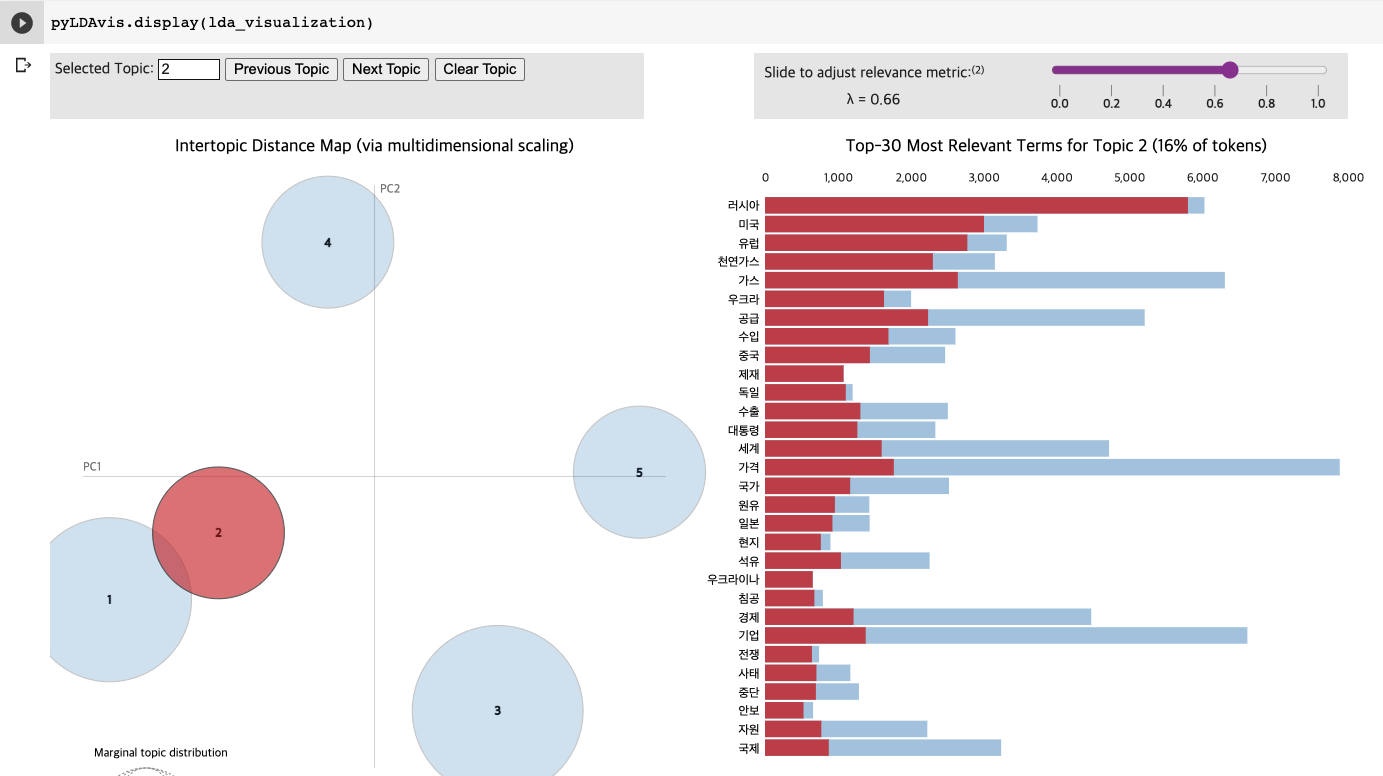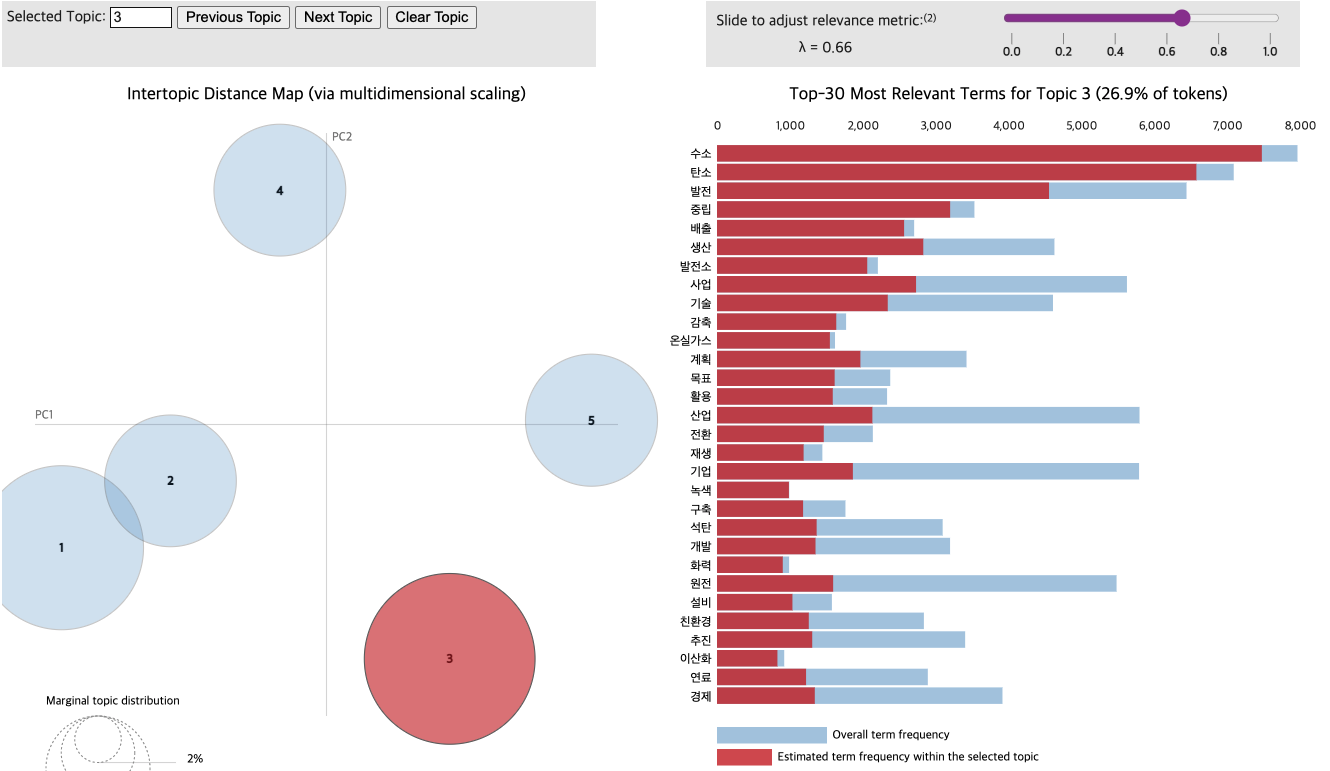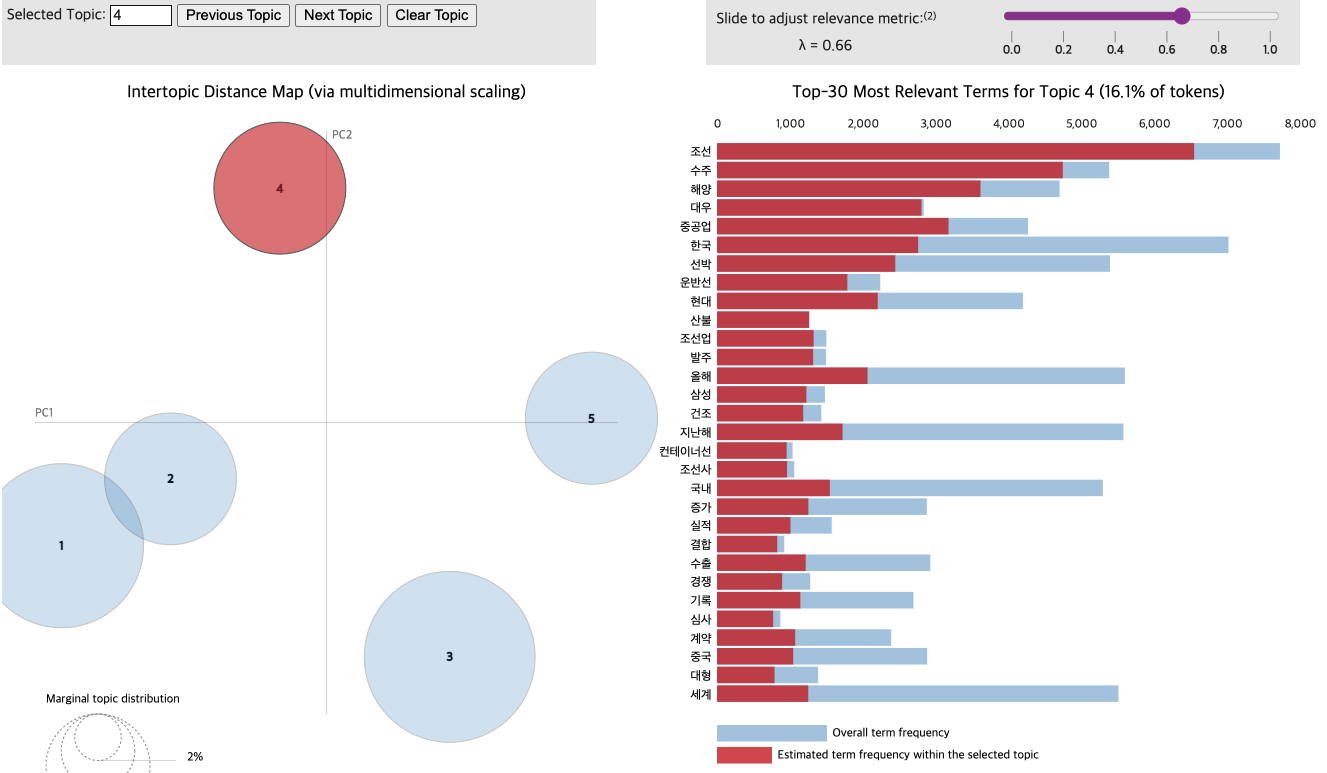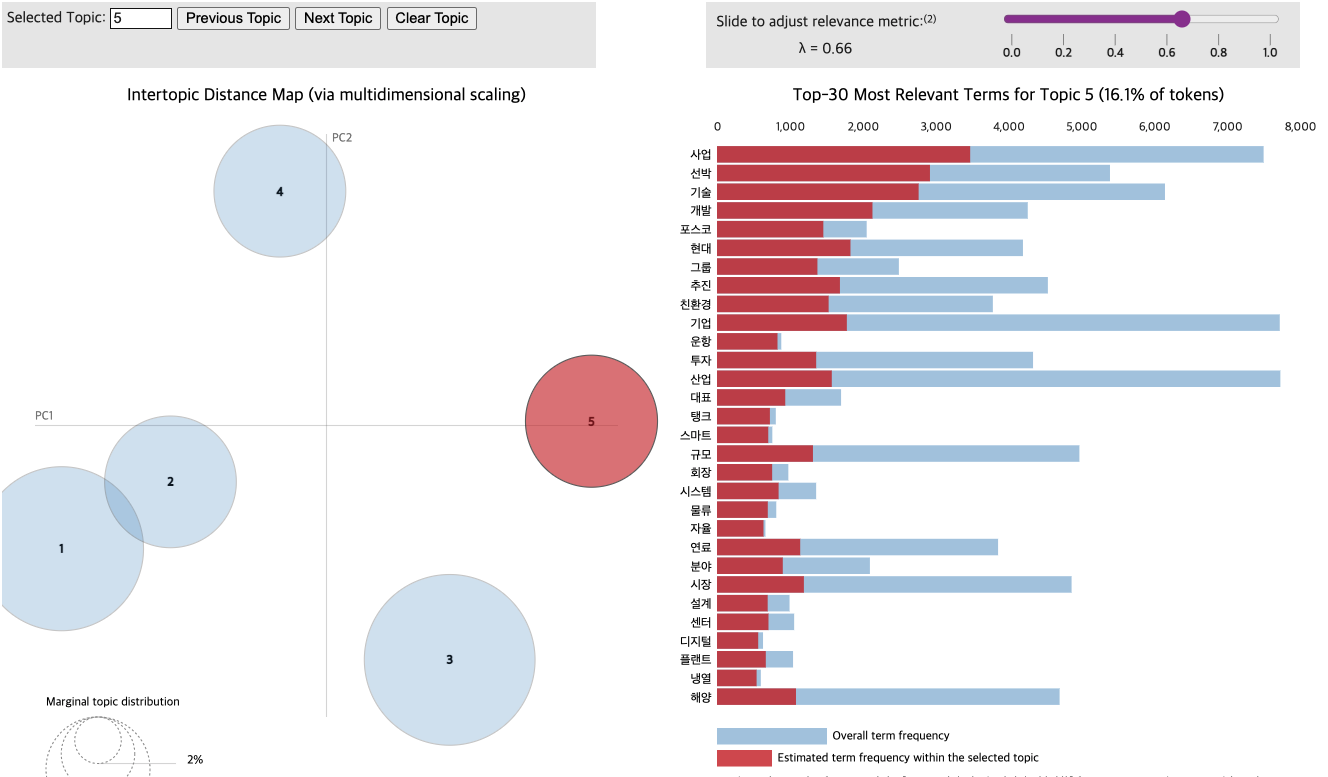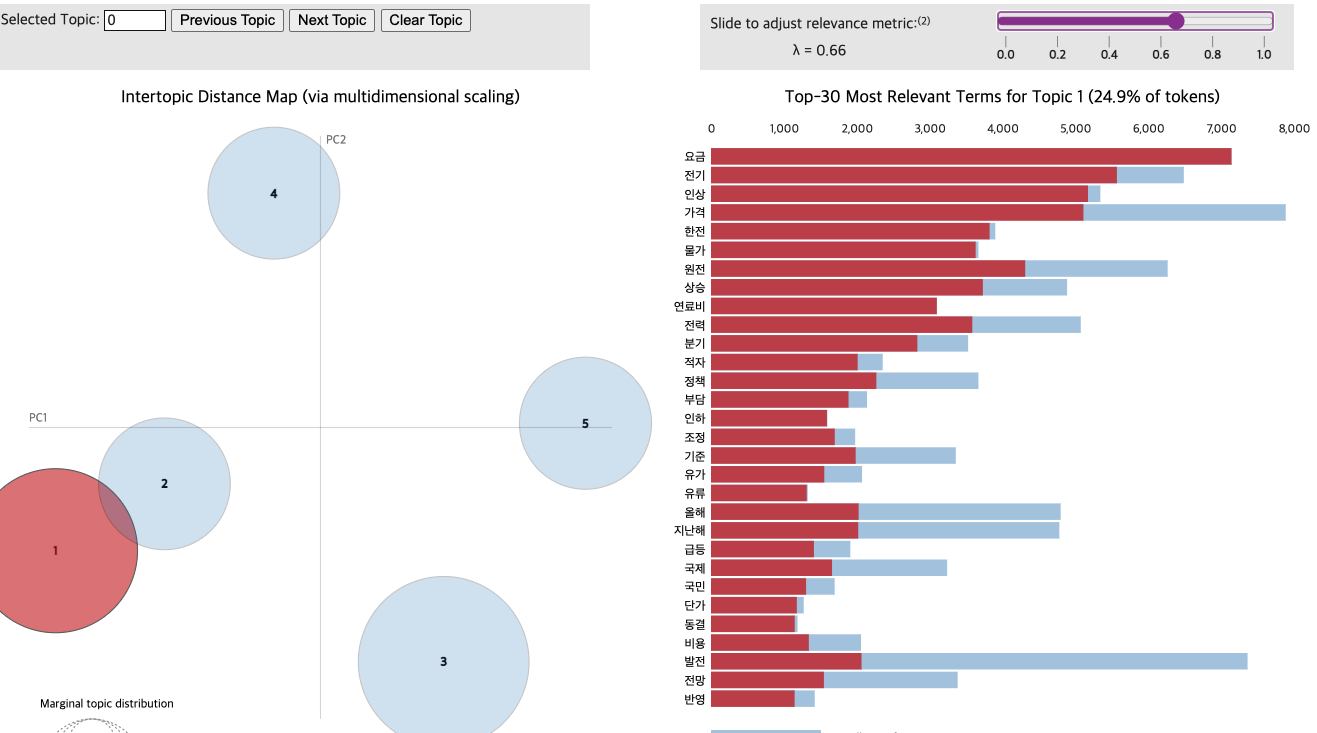

해석을 해보자면 이렇다. 
- Topic 1 : 연료비 상승에 따른 전기 요금 인상과 이로 인한 물가 상승 관련
- Topic 2 : 러시아의 우크라이나 침략에 따른 미국, 유럽 등 국제 사회의 천연가스 수입 관련
- Topic 3 : '탄소', '중립' 등 키워드로 보면, 그나마 기후위기와 관련. 그러나 LNG는 '친환경'이라는 내러티브
- Topic 4 : 산업계  기사 - 대우조선해양, 조선 업계 관련 
- Topic 5 : 산업계 기사 - 포스코, 선박 사업 관련

--> 분석을 해보자면, LNG = 화석연료라는 인식이 기사에서 잡히지 않음

## 5. 언론사 별로 볼까? 

- 경제지(매경, 한경, 서경), 보수지(조선, 중앙), 진보지(한겨레, 경향) 3그룹으로 나눠서 워드 클라우드 그려보기... 

In [49]:
import pandas as pd
df = pd.read_csv('/content/LNG_final.csv')

In [50]:
df.head(3)

,Unnamed: 0,agency,where,when,title,content,processed_content,agency_pick
0,0,중앙SUNDAY,T3면 1단,2022-07-23,"대우조선 부채율 547%, 작년 영업손실 1조7546억 ‘기초체력’ 떨어져",대우조선해양은 최악의 상황을 피했지만 그렇다고 앞날이 밝은 건 아니다 올해 들어 고...,"['대우', '조선', '해양', '최악', '상황', '그렇', '앞날', '올해...",NaN
1,1,한국경제,A27면 1단,2022-07-23,"[사설] 노사 협상 타결은 미봉…산은, 대우조선 원칙대로 처리하라",51일을 끌어온 대우조선해양 하청업체 노동조합의 파업이 어제 노사협상 타결로 끝났다...,"['대우', '조선', '해양', '하청', '업체', '노동조합', '파업', '...",언론사 선정
2,2,서울경제,3면 TOP,2022-07-23,'최대불씨' 손배소 결론 못내…경영정상화서 매각까지 첩첩산중,대우조선 파업 종료 상처만 남은 하청파업 51일2조대 적자에 8000억 추가손실세계...,"['대우', '조선', '파업', '종료', '상처', '하청', '파업', '조대...",언론사 선정


In [55]:
mae = df[df.agency == '매일경제']
han = df[df.agency == '한국경제']
seo = df[df.agency ==' 서울경제']
economy = pd.concat([mae, han, seo])
len(economy)

767

In [52]:
cho = df[df.agency == '조선일보']
joong = df[df.agency == '중앙일보']
joong_sun = df[df.agency =='중앙SUNDAY']
conservative = pd.concat([cho, joong, joong_sun])
len(conservative)

266

In [53]:
hankyoreh = df[df.agency == '한겨레']
kyung = df[df.agency =='경향신문']
progressive = pd.concat([hankyoreh, kyung])
len(progressive)

174

### 경제지 워드 크라우드

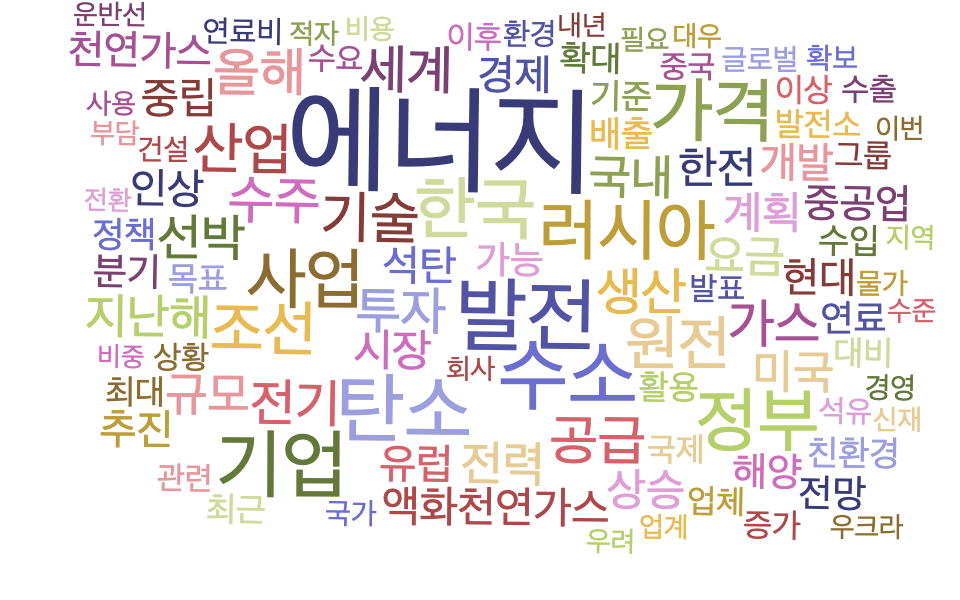

### 보수지 워드 크라우드

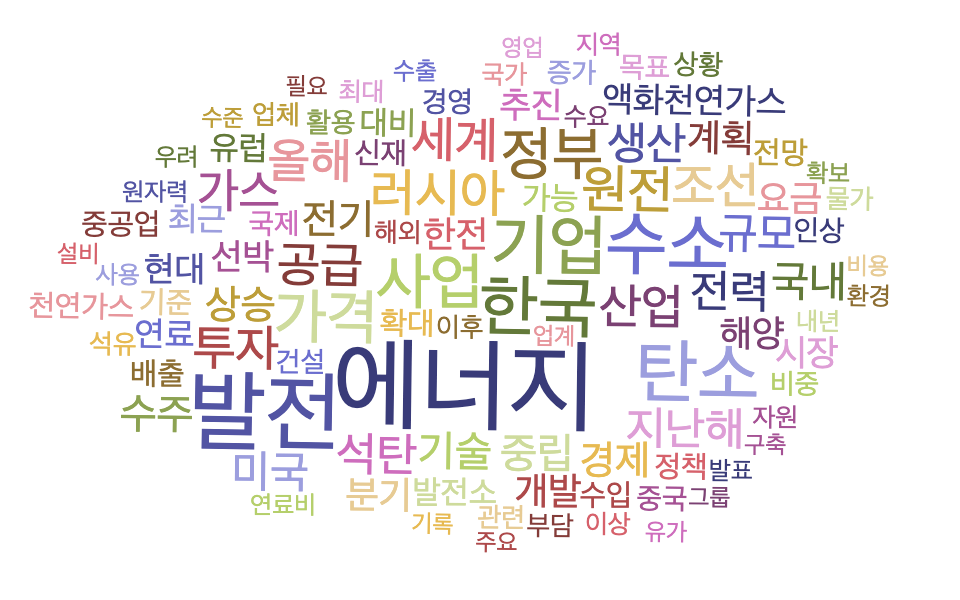

### 진보지 워드 크라우드

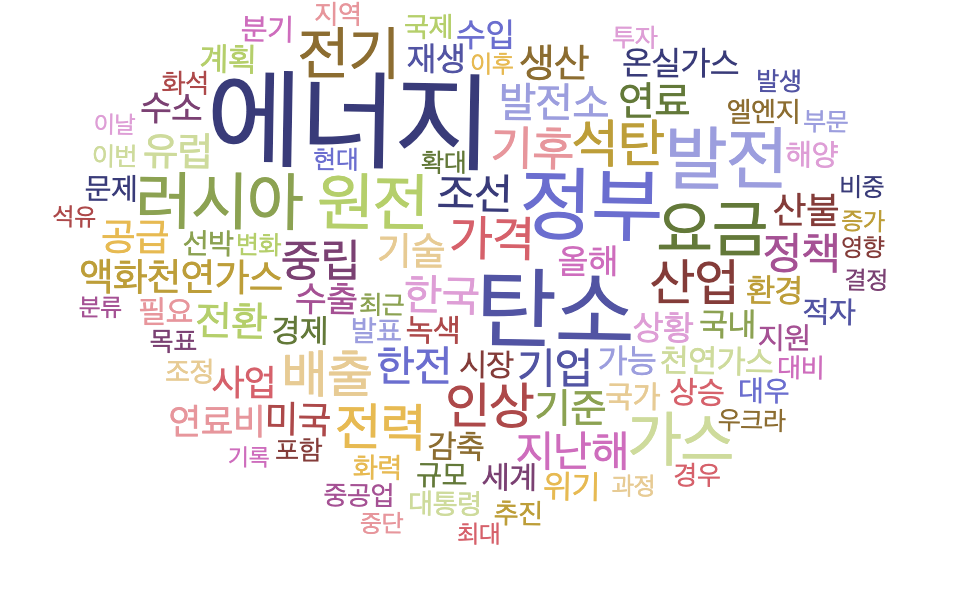

진보지에서 그나마 '화석' , '위기' 키워드 있음 ㅎㅎ 